## **NLP Tutorial: Text Classification USing Gensim Word Embeddings**

#### Gensim is an open-source library for unsupervised topic modeling, document indexing, retrieval by similarity, and other natural language processing functionalities, using modern statistical machine learning.

* Gensim overview: https://radimrehurek.com/gensim/intro.html#what-is-gensim

* documentataion: https://radimrehurek.com/gensim/auto_examples/index.html

* All gensim models are listed on this page: https://github.com/RaRe-Technologies/gensim-data

### **word2vec-google-news-300 Model**

* based and trained on Google News data.

* Load Google News Word2vec model from gensim library

In [1]:
import gensim.downloader as api
# This is a huge model (~1.6 gb) and it will take some time to load

wv = api.load('word2vec-google-news-300')
# in here we can sepcify which dataset or what kind of word embedding we need to download.
#

[==================================================] 100.0% 1662.8/1662.8MB downloaded


* These simillarites are based on the context thay appear. not because of synonims or antonyms.

* There are many trained word vectors avilable on the internet like Gensim,Spacy,PyTorch we load those vectors using these libraries.

* Word2Vec & Glove are different techniques / algorithms.

* Google news 300 / twitter 25 are the data sets that each model are trained on.

In [3]:
wv.similarity(w1="great", w2="great")

1.0

In [2]:
wv.similarity(w1="great", w2="good")

0.729151

In [22]:
wv_great = wv["great"]
wv_good = wv["good"]

In [23]:
wv_great.shape, wv_good.shape

((300,), (300,))

### **Fake vs Real News Classification Using This Word2Vec Embeddings**

* Fake news refers to misinformation or disinformation in the country which is spread through word of mouth and more recently through digital communication such as What's app messages, social media posts, etc.

* Fake news spreads faster than real news and creates problems and fear among groups and in society.

* We are going to address these problems using classical NLP techniques and going to classify whether a given message/ text is **Real or Fake Message**.

* We will use **glove embeddings** from spacy which is trained on massive wikipedia dataset to pre-process and text vectorization and apply different classification algorithms.

### **Dataset**

Credits: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

* This data consists of two columns. - Text - label

* Text is the statements or messages regarding a particular event/situation.

* label feature tells whether the given text is Fake or Real.

* As there are only 2 classes, this problem comes under the **Binary Classification.**

In [28]:
import pandas as pd
import csv
import numpy as np

#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_csv("/Fake_Real_Data.csv")

#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [29]:
#check the distribution of labels
df['label'].value_counts()

,count
label,
Fake,5000
Real,4900


In [30]:
#Add the new column which gives a unique number to each of these labels

df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})

#check the results with top 5 rows
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


### **Now we will convert the text into a vector using gensim's word2vec embeddings.We will do this in three steps,**

1. Preprocess the text to remove stop words, punctuations and get lemma for each word
2. Get word vectors for each of the words in a pre-processed sentece
3. Take a mean of all word vectors to derive the numeric representation of the entire news article

* First let's explore **get_mean_vector** api of gensim to see how it works

In [71]:
r1 = np.mean([wv_good, wv_great],axis=0) # using numpy

In [72]:
wv_good[:5]

array([ 0.04052734,  0.0625    , -0.01745605,  0.07861328,  0.03271484],
      dtype=float32)

In [73]:
wv_great[:5]

array([ 0.07177734,  0.20800781, -0.02844238,  0.17871094,  0.1328125 ],
      dtype=float32)

In [77]:
r1[:5] # avarage vector values of full sentence embedding

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

In [75]:
r2 = wv.get_mean_vector(["good", "great"],pre_normalize=False)

In [76]:
r2[:5]

# avarage vector values of full sentence embedding using 'get_mean_vector'.
# see the values are simillar.

array([ 0.05615234,  0.1352539 , -0.02294922,  0.12866211,  0.08276367],
      dtype=float32)

## **1. Preprocessing**

In [31]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 742.4 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


* Now let's write the function that can do preprocessing and vectorization both

In [42]:
import spacy
nlp = spacy.load("en_core_web_lg") # if this fails then run "python -m spacy download en_core_web_lg" to download that model

def preprocess_and_vectorize(text):
    # remove stop words and lemmatize the text
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)

    return wv.get_mean_vector(filtered_tokens)
    # the get_mean_vector is explained below

We use *'return wv.get_mean_vector(filtered_tokens)'* here instead of *'return(filtered_tokens)'* because the *filtered_tokens* are list of words in a sentence. but we are interested in embedding of entire sentence. That's why.

In [45]:
v = preprocess_and_vectorize("Don't worry if you don't understand ML and DL")
v.shape

(300,)

## **2. Vectorization Process**

we saw how directly vectorization happen in one word when we use word2vec-google-news-300 Model in above example. but how about a sentence.

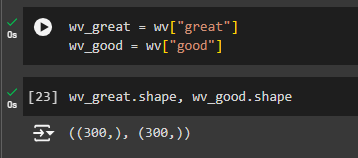

so if we deep dive how embeddings happen in a sentence. the sentence is this "Don't worry if you don't understand ML and DL" , after remove stop words and lemmatize the text we get "worry" "understand" first we get 300 size vector for "worry" and then we get the same size vector for "understand". then we avrage those 2 words vectors. after averaging we get another vector size of 300 and it is the sentense embedding. this is the common method we use in NLP.

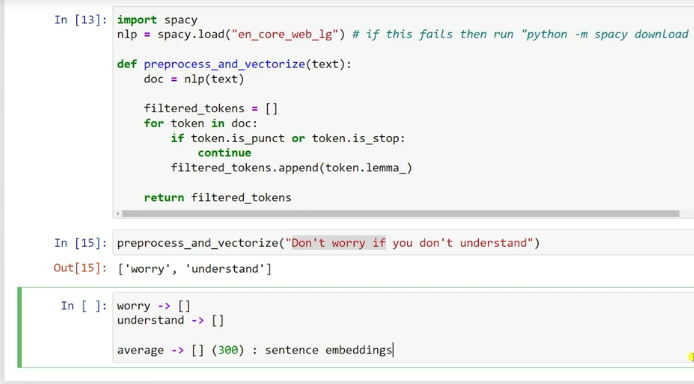

by using the function, if we provide list of tokens it will provide avrage vector values of the both words.

In [56]:
wv.get_mean_vector(["worry", "understand"])
# it prints all 300 vector values.

array([ 0.00235079, -0.00284596, -0.03638233,  0.00413919, -0.10635224,
        0.05758579,  0.13348952, -0.00689176,  0.05995331, -0.02875906,
       -0.02279907, -0.06939262, -0.01549996,  0.03538099, -0.0873947 ,
        0.10044542,  0.02490648,  0.11501945,  0.00442711, -0.07228819,
       -0.04447255,  0.02785169,  0.03338735,  0.02222995,  0.07053161,
        0.06723307,  0.03483712, -0.0873695 ,  0.04152397, -0.0969665 ,
       -0.00914938,  0.00555944, -0.0277799 , -0.00701522,  0.05281431,
       -0.01066206,  0.02466576,  0.02378148,  0.0279402 ,  0.05527755,
        0.01359304, -0.01062085,  0.06734448, -0.03492254, -0.08421434,
       -0.04324378, -0.03578918, -0.00817786, -0.02093195,  0.01856531,
       -0.07064191,  0.05023994, -0.03036207, -0.0412168 , -0.00684169,
        0.05189689, -0.04097777, -0.05789134,  0.044417  , -0.0470418 ,
       -0.01475445,  0.01373999, -0.00459672,  0.00419459,  0.04307397,
       -0.01500929, -0.08037488,  0.05358911, -0.0211829 , -0.00



---



### **Prooving above mentioned part of vectorization**

In [57]:
v1 = wv["worry"]
v2 = wv["understand"]

import numpy as np
np.mean([v1,v2],axis=0)
#print the mean vector values of these 2 words. all 300 values.

array([ 0.00976562, -0.00561523, -0.08905029,  0.01330566, -0.2709961 ,
        0.14746094,  0.3408203 , -0.01840591,  0.15161133, -0.06945801,
       -0.05749512, -0.17822266, -0.03805542,  0.08730698, -0.22216797,
        0.2578125 ,  0.06481934,  0.29589844,  0.00537109, -0.1875    ,
       -0.1159668 ,  0.0715332 ,  0.08691406,  0.05912399,  0.18359375,
        0.17687988,  0.09130859, -0.22705078,  0.10522461, -0.2475586 ,
       -0.02436638,  0.01245117, -0.06616211, -0.02587891,  0.13476562,
       -0.02604675,  0.06582642,  0.0612793 ,  0.07128906,  0.13867188,
        0.03234863, -0.03295898,  0.17736816, -0.08789062, -0.21777344,
       -0.11010742, -0.08728027, -0.01922607, -0.04943848,  0.05273438,
       -0.18066406,  0.13122559, -0.07498932, -0.10064697, -0.01171875,
        0.12963867, -0.10766602, -0.14624023,  0.11303711, -0.12280273,
       -0.03540039,  0.03601074, -0.01379395,  0.01042175,  0.1105957 ,
       -0.03820801, -0.20751953,  0.1352539 , -0.0625    , -0.01

In [58]:
v1 = wv["worry"]
v2 = wv["understand"]

import numpy as np
np.mean([v1,v2],axis=0).shape
# this prints the vector size.look at the vector size here it's 300.

(300,)

In [59]:
v1 = wv["worry"]
v2 = wv["understand"]

import numpy as np
np.mean([v1,v2],axis=0)[:3]
#lets print 1st 3 numbers

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

In [54]:
wv.get_mean_vector(["worry", "understand"])[:3]

array([ 0.00235079, -0.00284596, -0.03638233], dtype=float32)

* it's not giving the same result. here you can see some diff. in vector values given by the function (of 'word2vec-google-news-300' model) . lets break down it. doc: https://radimrehurek.com/gensim/models/keyedvectors.html

* the pre_normalization is by default = true we need to set it to false.

In [61]:
wv.get_mean_vector(["worry", "understand"],pre_normalize=False)[:3]
# there we go the mean/average vector values are same

array([ 0.00976562, -0.00561523, -0.08905029], dtype=float32)

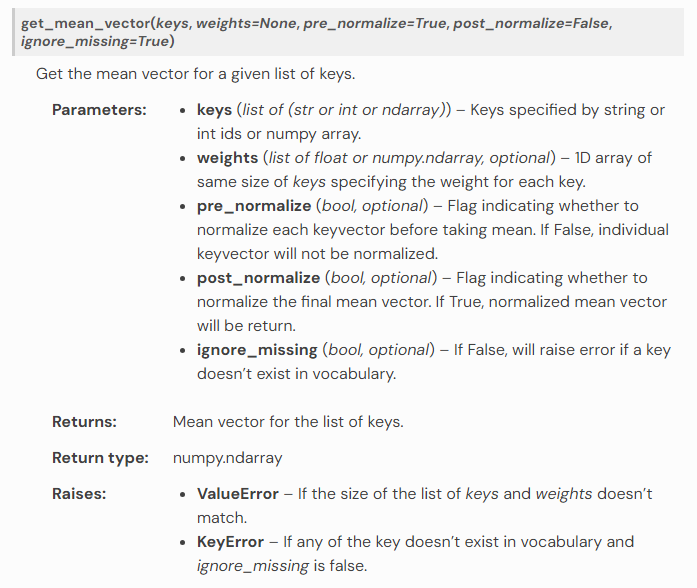



---



#### **finally now we can create the 3rd column "vector"**

In [44]:
#this query takes few minutes to complete :)

df['vector'] = df['Text'].apply(lambda text: preprocess_and_vectorize(text))

In [62]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[0.008657642, 0.019024342, -0.011917442, 0.032..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[0.010864096, 0.007960429, 0.0011915653, 0.014..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[0.018134918, 0.0062743523, -0.005872244, 0.03..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[0.01255197, 0.012613623, 5.9780963e-05, 0.021..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.0019059887, 0.011889367, 0.0035395357, 0.0..."


### **Train-Test splitting**

In [63]:
from sklearn.model_selection import train_test_split


#Do the 'train-test' splitting with test size of 20% with random state of 2022 and stratify sampling too
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022,
    stratify=df.label_num
)

### **Reshaping the X_train and X_test so as to fit for models**

In [64]:
print("Shape of X_train before reshaping: ", X_train.shape)
print("Shape of X_test before reshaping: ", X_test.shape)


X_train_2d = np.stack(X_train)
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)
# creating 2D vector

Shape of X_train before reshaping:  (7920,)
Shape of X_test before reshaping:  (1980,)
Shape of X_train after reshaping:  (7920, 300)
Shape of X_test after reshaping:  (1980, 300)


In [65]:
X_train[:2]

array([array([-2.58219568e-03,  6.66544260e-03,  2.52646767e-03,  3.95730063e-02,
              -1.41182542e-02, -7.22123589e-03,  3.15938070e-02, -3.18326391e-02,
               1.62770562e-02,  2.15391051e-02, -2.36972049e-02, -3.72144543e-02,
              -6.70092739e-03,  1.64224133e-02, -2.48180293e-02,  4.60469536e-02,
               6.02065027e-03,  2.53213309e-02,  4.08343738e-03, -3.32745500e-02,
               6.01468608e-03,  1.92604307e-02,  4.28487025e-02, -2.15403945e-03,
               2.04510838e-02,  3.04712215e-03, -2.73784697e-02, -1.53319014e-03,
               6.67838380e-03, -3.27401888e-03, -1.53824072e-02,  9.19036320e-05,
              -2.74383668e-02, -3.54807038e-04, -1.12002371e-02, -1.66487973e-02,
               1.40579836e-02,  2.69189221e-03, -4.44610231e-03,  3.41382883e-02,
               5.02199680e-03, -1.35964267e-02,  4.29993980e-02,  1.10096289e-02,
              -5.67582203e-03, -1.63680799e-02, -2.08231565e-02,  8.67405720e-03,
              -1

In [66]:
X_train_2d[:2]

array([[-2.58219568e-03,  6.66544260e-03,  2.52646767e-03,
         3.95730063e-02, -1.41182542e-02, -7.22123589e-03,
         3.15938070e-02, -3.18326391e-02,  1.62770562e-02,
         2.15391051e-02, -2.36972049e-02, -3.72144543e-02,
        -6.70092739e-03,  1.64224133e-02, -2.48180293e-02,
         4.60469536e-02,  6.02065027e-03,  2.53213309e-02,
         4.08343738e-03, -3.32745500e-02,  6.01468608e-03,
         1.92604307e-02,  4.28487025e-02, -2.15403945e-03,
         2.04510838e-02,  3.04712215e-03, -2.73784697e-02,
        -1.53319014e-03,  6.67838380e-03, -3.27401888e-03,
        -1.53824072e-02,  9.19036320e-05, -2.74383668e-02,
        -3.54807038e-04, -1.12002371e-02, -1.66487973e-02,
         1.40579836e-02,  2.69189221e-03, -4.44610231e-03,
         3.41382883e-02,  5.02199680e-03, -1.35964267e-02,
         4.29993980e-02,  1.10096289e-02, -5.67582203e-03,
        -1.63680799e-02, -2.08231565e-02,  8.67405720e-03,
        -1.27506657e-02,  3.22506502e-02, -1.29026920e-0

### **Train Machine Learning Model**

try Random forest, decision tree, naive bayes etc classifiers as well but **gradient boosting classifier** gave the best performance of all.

In [67]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

#1. creating a GradientBoosting model object
clf = GradientBoostingClassifier()

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)


#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)


#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1000
           1       0.97      0.99      0.98       980

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



### **Make some predictions**

In [69]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vectors = [preprocess_and_vectorize(n) for n in test_news]
clf.predict(test_news_vectors)
# actual values = real,fake,fake

array([1, 0, 0])

### **Confusion Matrix for Best Model**

Text(95.72222222222221, 0.5, 'Truth')

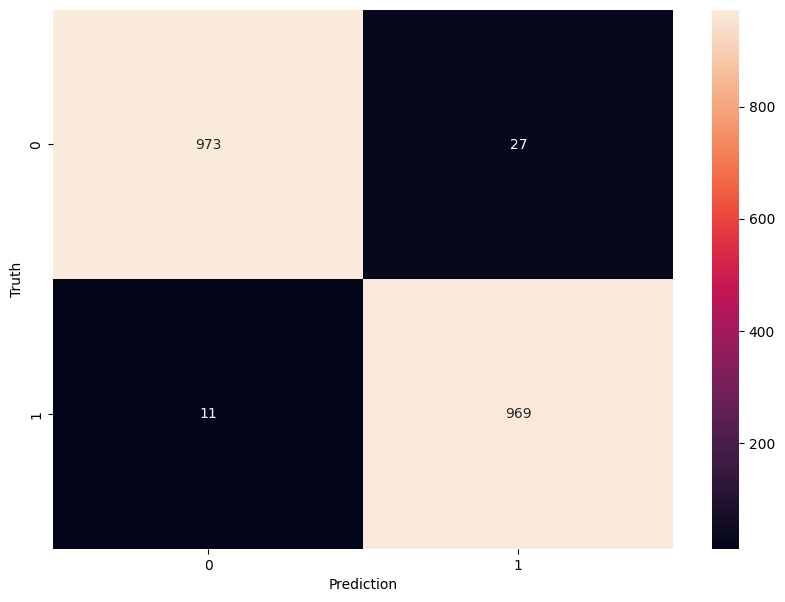

In [70]:
#finally print the confusion matrix for the best model (GradientBoostingClassifier)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm


from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')